In [20]:
# from spacy_langdetect import LanguageDetector
# from spacy.language import Language
# import spacy
import pandas as pd
from frequentist_treatment_nlp import *
import nltk
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, mean_squared_error
from nltk.stem.snowball import SnowballStemmer
import regex
import re
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,GRU,LSTM,Embedding, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SpatialDropout1D,Dropout,Bidirectional,Conv1D,GlobalMaxPooling1D, MaxPooling1D, LeakyReLU, Flatten, InputLayer, Input, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping, History
import tensorflow as tf
from sklearn.manifold import TSNE
from tensorflow.keras.backend import clear_session

In [15]:
tf.config.list_physical_devices()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [16]:
path = 'C:/Users/32mor/OneDrive/Documents/Polytechnique/NLP & Natixis/starting_kit/data'

In [17]:
os.chdir(path)
X, y_cat, y_reg = hx.data_expander(all_data=True)
y = pd.concat([y_cat,y_reg],axis=1)

In [18]:
unsaved  = False
if unsaved:
     print('unsaved')
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
     pipe_ecb = Full_pipeline_nlp('ecb', 0.3, 300,translate=True)
     pipe_fed = Full_pipeline_nlp('fed',0.3, 300, translate=True)
     pipe_num = numerical_pipeline()
     test_pipe  = full_pipeline(pipe_fed, pipe_ecb, pipe_num)
     X_fed_train, X_ecb_train, X_num_train = test_pipe.fit_transform(X_train)
     X_fed_val, X_ecb_val, X_num_val = test_pipe.transform(X_val)
     X_fed_test, X_ecb_test, X_num_test = test_pipe.transform(X_test)


     y_train_reg = y_train.target_reg
     y_train_cat = y_train.target_classif
     y_test_reg = y_test.target_reg
     y_test_cat = y_test.target_classif
     y_val_reg = y_val.target_reg
     y_val_cat = y_val.target_classif
     os.chdir(path)
     saves = [X_fed_train, X_fed_test, X_fed_val, X_ecb_train, X_ecb_test, 
                    X_ecb_val, X_num_train,X_num_test, X_num_val, y_test_cat,
                    y_test_reg, y_train_reg, y_train_cat, y_val_cat, y_val_reg]
     for element in saves:
          vnames = [name for name in globals() if globals()[name] is element][0]
          np.save(f'{vnames}.npy',element)

else:
     print('saved')
     for element in os.listdir():
          if 'npy' in element :
               if element not in ['element.npy','__.npy']:
                    str = element
                    globals()[str.split('.')[0]] = np.load(element)

day_max = 20
speeches_train = int(len(X_fed_train)/20)
speeches_val = int(len(X_ecb_val)/20)
speeches_test = int(len(X_ecb_test)/20)
components = 300
X_fed_lstm_train = X_fed_train.reshape((speeches_train, day_max, components))
X_ecb_lstm_train = X_ecb_train.reshape((speeches_train, day_max, components))
# X_fed_lstm_test = X_fed_test.reshape((speeches_test, day_max, components))
X_ecb_lstm_test = X_ecb_test.reshape((speeches_test, day_max, components))
X_fed_lstm_val = X_fed_val.reshape((speeches_val, day_max, components))
X_ecb_lstm_val = X_ecb_val.reshape((speeches_val, day_max, components))
lstm_shape = (day_max, components)
shape_num = day_max

saved


In [22]:
def multi_input_output_lstm_full(shape_nlp, shape_num):
    input_nlp_fed = Input(shape=(shape_nlp[0], shape_nlp[1]))
    input_nlp_bce = Input(shape=(shape_nlp[0], shape_nlp[1]))
    input_num = Input(shape=(shape_num, 1))


    w = LSTM(100, return_sequences=True)(input_nlp_fed)
    w = Dropout(0.3)(w)
    #w = BatchNormalization()(w)
    w = LSTM(40, return_sequences=False)(w)
    w = Dropout(0.3)(w)
    w = Model(inputs=input_nlp_fed, outputs=w)


    x = LSTM(100, return_sequences=True)(input_nlp_bce)
    x = Dropout(0.3)(x)
    #x = BatchNormalization()(x)
    x = LSTM(40, return_sequences=False)(x)
    #x = Dropout(0.3)(x)
    x = Model(inputs=input_nlp_bce, outputs=x)

    # the second branch opreates on the second input
    y = LSTM(100, return_sequences=False)(input_num)
    y = Dropout(0.3)(y)
    #y = BatchNormalization()(y)
    # y = LSTM(40, return_sequences=False)(y)
    # y = Dropout(0.3)(y)
    y = Model(inputs=input_num, outputs=y)
    # combine the output of the two branches
    combined = concatenate([w.output, x.output, y.output])

    z = Dense(64, activation='relu')(combined)
    z = Dropout(0.3)(z)
    

    # z = Dense(64, activation='relu')(z)
    # z = Dropout(0.3)(z)
    out_reg = Dense(1, activation='linear')(z)
    
    # dense_class = Dense(40, activation = 'relu')(dropout_2)
    classi = BatchNormalization()(z)
    # classi = Dense(64)(classi)
    # classi = LeakyReLU(0.3)(classi)
    # classi = Dropout(0.5)(classi)
    out_class = Dense(1, activation = 'sigmoid')(classi)
    model = Model(inputs=[w.input, x.input, y.input], outputs=[out_reg, out_class])

    return model

In [23]:
def objective_full(trial):
    # Clear clutter from previous Keras session graphs.
    clear_session()
    model = multi_input_output_lstm_full

    # We compile our model with a sampled learning rate.
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    model=multi_input_output_lstm_full(lstm_shape, shape_num)

    early_stop = EarlyStopping(monitor='val_loss', patience=3)
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss=['mse',tf.keras.losses.binary_crossentropy], 
                    optimizer=optimizer)

    history = model.fit([X_fed_lstm_train, X_ecb_lstm_train, X_num_train], 
                        [y_train_reg,y_train_cat], 
                        epochs=50, 
                        batch_size=128, verbose=2,
                        callbacks=[early_stop, tensorboard_callback, ], 
                        validation_data=([X_fed_lstm_val,X_ecb_lstm_val, X_num_val],[y_val_reg,y_val_cat]))


    # Evaluate the model accuracy on the validation set.
    score = model.evaluate([X_fed_lstm_val,X_ecb_lstm_val, X_num_val],[y_val_reg,y_val_cat], verbose=0)
    return score[1]


In [25]:
import datetime

In [28]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_full, n_trials=10, timeout=None)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

[I 2022-03-27 22:30:54,071] A new study created in memory with name: no-name-6d1d0c9f-70e4-4f78-828b-b2c747a76e0e


Epoch 1/50
8/8 - 17s - loss: 2.0699 - dense_1_loss: 1.1565 - dense_2_loss: 0.9135 - val_loss: 2.4078 - val_dense_1_loss: 1.7113 - val_dense_2_loss: 0.6966
Epoch 2/50
8/8 - 3s - loss: 2.0123 - dense_1_loss: 1.1332 - dense_2_loss: 0.8792 - val_loss: 2.3406 - val_dense_1_loss: 1.6438 - val_dense_2_loss: 0.6968
Epoch 3/50
8/8 - 3s - loss: 1.9216 - dense_1_loss: 1.0882 - dense_2_loss: 0.8334 - val_loss: 2.2765 - val_dense_1_loss: 1.5793 - val_dense_2_loss: 0.6972
Epoch 4/50
8/8 - 3s - loss: 1.8760 - dense_1_loss: 1.0354 - dense_2_loss: 0.8406 - val_loss: 2.2209 - val_dense_1_loss: 1.5231 - val_dense_2_loss: 0.6978
Epoch 5/50
8/8 - 3s - loss: 1.8696 - dense_1_loss: 1.0232 - dense_2_loss: 0.8464 - val_loss: 2.1681 - val_dense_1_loss: 1.4701 - val_dense_2_loss: 0.6980
Epoch 6/50
8/8 - 3s - loss: 1.7774 - dense_1_loss: 0.9575 - dense_2_loss: 0.8198 - val_loss: 2.1191 - val_dense_1_loss: 1.4208 - val_dense_2_loss: 0.6983
Epoch 7/50
8/8 - 3s - loss: 1.6741 - dense_1_loss: 0.9179 - dense_2_loss: 0

[I 2022-03-27 22:33:18,787] Trial 0 finished with value: 0.35800009965896606 and parameters: {'learning_rate': 5.290969533029896e-05}. Best is trial 0 with value: 0.35800009965896606.


Epoch 1/50
8/8 - 13s - loss: 9.1071 - dense_1_loss: 8.3425 - dense_2_loss: 0.7646 - val_loss: 2.2273 - val_dense_1_loss: 1.5395 - val_dense_2_loss: 0.6878
Epoch 2/50
8/8 - 3s - loss: 1.9391 - dense_1_loss: 1.2486 - dense_2_loss: 0.6905 - val_loss: 2.0549 - val_dense_1_loss: 1.3705 - val_dense_2_loss: 0.6845
Epoch 3/50
8/8 - 2s - loss: 1.7487 - dense_1_loss: 1.0646 - dense_2_loss: 0.6840 - val_loss: 2.3957 - val_dense_1_loss: 1.6998 - val_dense_2_loss: 0.6959
Epoch 4/50
8/8 - 2s - loss: 1.8001 - dense_1_loss: 1.0997 - dense_2_loss: 0.7004 - val_loss: 2.3323 - val_dense_1_loss: 1.6469 - val_dense_2_loss: 0.6855
Epoch 5/50
8/8 - 2s - loss: 1.7588 - dense_1_loss: 1.0656 - dense_2_loss: 0.6931 - val_loss: 2.3063 - val_dense_1_loss: 1.5819 - val_dense_2_loss: 0.7244


[I 2022-03-27 22:33:45,205] Trial 1 finished with value: 1.5819408893585205 and parameters: {'learning_rate': 0.06354347947646927}. Best is trial 1 with value: 1.5819408893585205.


Epoch 1/50
8/8 - 13s - loss: 1.9201 - dense_1_loss: 1.0378 - dense_2_loss: 0.8824 - val_loss: 2.1442 - val_dense_1_loss: 1.4604 - val_dense_2_loss: 0.6838
Epoch 2/50
8/8 - 3s - loss: 1.8722 - dense_1_loss: 1.0212 - dense_2_loss: 0.8510 - val_loss: 2.1308 - val_dense_1_loss: 1.4468 - val_dense_2_loss: 0.6840
Epoch 3/50
8/8 - 2s - loss: 1.8104 - dense_1_loss: 0.9877 - dense_2_loss: 0.8226 - val_loss: 2.1179 - val_dense_1_loss: 1.4338 - val_dense_2_loss: 0.6841
Epoch 4/50
8/8 - 3s - loss: 1.8667 - dense_1_loss: 0.9891 - dense_2_loss: 0.8776 - val_loss: 2.1042 - val_dense_1_loss: 1.4199 - val_dense_2_loss: 0.6843
Epoch 5/50
8/8 - 2s - loss: 1.8288 - dense_1_loss: 0.9707 - dense_2_loss: 0.8581 - val_loss: 2.0911 - val_dense_1_loss: 1.4065 - val_dense_2_loss: 0.6845
Epoch 6/50
8/8 - 2s - loss: 1.8124 - dense_1_loss: 0.9641 - dense_2_loss: 0.8483 - val_loss: 2.0792 - val_dense_1_loss: 1.3944 - val_dense_2_loss: 0.6848
Epoch 7/50
8/8 - 3s - loss: 1.8195 - dense_1_loss: 0.9455 - dense_2_loss: 0

[I 2022-03-27 22:36:06,558] Trial 2 finished with value: 0.9060977697372437 and parameters: {'learning_rate': 1.0778301692599004e-05}. Best is trial 1 with value: 1.5819408893585205.


Epoch 1/50
8/8 - 13s - loss: 1.4338 - dense_1_loss: 0.5944 - dense_2_loss: 0.8394 - val_loss: 1.0212 - val_dense_1_loss: 0.3319 - val_dense_2_loss: 0.6893
Epoch 2/50
8/8 - 3s - loss: 0.8705 - dense_1_loss: 0.2184 - dense_2_loss: 0.6521 - val_loss: 0.9111 - val_dense_1_loss: 0.2197 - val_dense_2_loss: 0.6914
Epoch 3/50
8/8 - 2s - loss: 0.7984 - dense_1_loss: 0.2115 - dense_2_loss: 0.5869 - val_loss: 0.9781 - val_dense_1_loss: 0.2729 - val_dense_2_loss: 0.7052
Epoch 4/50
8/8 - 2s - loss: 0.6822 - dense_1_loss: 0.1855 - dense_2_loss: 0.4967 - val_loss: 0.9217 - val_dense_1_loss: 0.2190 - val_dense_2_loss: 0.7026
Epoch 5/50
8/8 - 2s - loss: 0.5798 - dense_1_loss: 0.1959 - dense_2_loss: 0.3839 - val_loss: 0.9719 - val_dense_1_loss: 0.2434 - val_dense_2_loss: 0.7284


[I 2022-03-27 22:36:32,510] Trial 3 finished with value: 0.2434360384941101 and parameters: {'learning_rate': 0.002252504473205948}. Best is trial 1 with value: 1.5819408893585205.


Epoch 1/50
8/8 - 13s - loss: 1.9053 - dense_1_loss: 1.0234 - dense_2_loss: 0.8819 - val_loss: 2.0776 - val_dense_1_loss: 1.3897 - val_dense_2_loss: 0.6879
Epoch 2/50
8/8 - 2s - loss: 1.7528 - dense_1_loss: 0.9330 - dense_2_loss: 0.8198 - val_loss: 2.0000 - val_dense_1_loss: 1.3131 - val_dense_2_loss: 0.6869
Epoch 3/50
8/8 - 2s - loss: 1.6545 - dense_1_loss: 0.8714 - dense_2_loss: 0.7832 - val_loss: 1.9270 - val_dense_1_loss: 1.2406 - val_dense_2_loss: 0.6864
Epoch 4/50
8/8 - 2s - loss: 1.6114 - dense_1_loss: 0.8205 - dense_2_loss: 0.7909 - val_loss: 1.8553 - val_dense_1_loss: 1.1693 - val_dense_2_loss: 0.6859
Epoch 5/50
8/8 - 2s - loss: 1.5433 - dense_1_loss: 0.7546 - dense_2_loss: 0.7887 - val_loss: 1.7912 - val_dense_1_loss: 1.1055 - val_dense_2_loss: 0.6857
Epoch 6/50
8/8 - 2s - loss: 1.4959 - dense_1_loss: 0.7377 - dense_2_loss: 0.7582 - val_loss: 1.7264 - val_dense_1_loss: 1.0408 - val_dense_2_loss: 0.6856
Epoch 7/50
8/8 - 2s - loss: 1.4164 - dense_1_loss: 0.6717 - dense_2_loss: 0

[I 2022-03-27 22:38:28,753] Trial 4 finished with value: 0.274245023727417 and parameters: {'learning_rate': 8.192568904136865e-05}. Best is trial 1 with value: 1.5819408893585205.


Epoch 1/50
8/8 - 12s - loss: 1.8660 - dense_1_loss: 1.0190 - dense_2_loss: 0.8470 - val_loss: 2.1811 - val_dense_1_loss: 1.4842 - val_dense_2_loss: 0.6969
Epoch 2/50
8/8 - 3s - loss: 1.8704 - dense_1_loss: 0.9891 - dense_2_loss: 0.8813 - val_loss: 2.1589 - val_dense_1_loss: 1.4628 - val_dense_2_loss: 0.6961
Epoch 3/50
8/8 - 2s - loss: 1.8237 - dense_1_loss: 0.9917 - dense_2_loss: 0.8320 - val_loss: 2.1372 - val_dense_1_loss: 1.4417 - val_dense_2_loss: 0.6955
Epoch 4/50
8/8 - 2s - loss: 1.8057 - dense_1_loss: 0.9713 - dense_2_loss: 0.8344 - val_loss: 2.1160 - val_dense_1_loss: 1.4211 - val_dense_2_loss: 0.6949
Epoch 5/50
8/8 - 3s - loss: 1.7868 - dense_1_loss: 0.9409 - dense_2_loss: 0.8459 - val_loss: 2.0951 - val_dense_1_loss: 1.4008 - val_dense_2_loss: 0.6943
Epoch 6/50
8/8 - 2s - loss: 1.7506 - dense_1_loss: 0.9364 - dense_2_loss: 0.8141 - val_loss: 2.0754 - val_dense_1_loss: 1.3815 - val_dense_2_loss: 0.6939
Epoch 7/50
8/8 - 2s - loss: 1.7298 - dense_1_loss: 0.9157 - dense_2_loss: 0

[I 2022-03-27 22:40:48,644] Trial 5 finished with value: 0.5523176789283752 and parameters: {'learning_rate': 2.2018199657043985e-05}. Best is trial 1 with value: 1.5819408893585205.


Epoch 1/50


KeyboardInterrupt: 

In [69]:
import datetime

In [70]:
# model=multi_input_output_lstm_full(lstm_shape, shape_num)
# early_stop = EarlyStopping(monitor='val_loss', patience=3)
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
# optimizer = Adam(learning_rate=0.0001)
# model.compile(loss=['mse',tf.keras.losses.binary_crossentropy], optimizer=optimizer)

In [29]:
# history = model.fit([X_fed_lstm_train, X_ecb_lstm_train, X_num_train], [y_train_reg,y_train_cat], epochs=50, batch_size=128, verbose=2,
        #  callbacks=[early_stop, tensorboard_callback, ], validation_split=0.2)

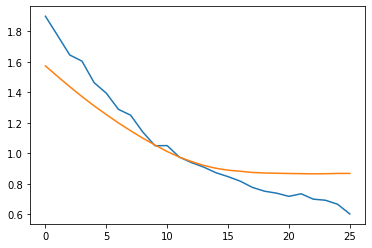

In [72]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])

In [86]:
model.save("mutli_inouts_outputs_model")

INFO:tensorflow:Assets written to: mutli_inouts_outputs_model\assets


INFO:tensorflow:Assets written to: mutli_inouts_outputs_model\assets


In [30]:
def multi_input_class_lstm_full(shape_nlp, shape_num):
    input_nlp_fed = Input(shape=(shape_nlp[0], shape_nlp[1]))
    input_nlp_bce = Input(shape=(shape_nlp[0], shape_nlp[1]))
    input_num = Input(shape=(shape_num, 1))


    w = LSTM(100, return_sequences=True)(input_nlp_fed)
    w = Dropout(0.3)(w)
    #w = BatchNormalization()(w)
    w = LSTM(40, return_sequences=False)(w)
    w = Dropout(0.3)(w)
    w = Model(inputs=input_nlp_fed, outputs=w)


    x = LSTM(100, return_sequences=True)(input_nlp_bce)
    x = Dropout(0.3)(x)
    #x = BatchNormalization()(x)
    x = LSTM(40, return_sequences=False)(x)
    #x = Dropout(0.3)(x)
    x = Model(inputs=input_nlp_bce, outputs=x)

    # the second branch opreates on the second input
    y = LSTM(100, return_sequences=False)(input_num)
    y = Dropout(0.3)(y)
    #y = BatchNormalization()(y)
    # y = LSTM(40, return_sequences=False)(y)
    # y = Dropout(0.3)(y)
    y = Model(inputs=input_num, outputs=y)
    # combine the output of the two branches
    combined = concatenate([w.output, x.output, y.output])

    z = Dense(64, activation='relu')(combined)
    z = Dropout(0.3)(z)
    classi = BatchNormalization()(z)
    classi = Dense(64)(classi)
    classi = LeakyReLU(0.3)(classi)
    classi = Dropout(0.5)(classi)
    z = Dense(64, activation='relu')(z)
    z = Dropout(0.3)(z)
    out_reg = Dense(1, activation='linear')(z)
    
    out_class = Dense(1, activation = 'sigmoid')(z)
    model = Model(inputs=[w.input, x.input, y.input], outputs=out_class)

    return model

In [31]:
def objective_class(trial):
    # Clear clutter from previous Keras session graphs.
    clear_session()
    model = multi_input_class_lstm_full()

    # We compile our model with a sampled learning rate.
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    model=multi_input_output_lstm_full(lstm_shape, shape_num)

    early_stop = EarlyStopping(monitor='val_loss', patience=3)
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss=['mse',tf.keras.losses.binary_crossentropy], 
                    optimizer=optimizer)

    history = model.fit([X_fed_lstm_train, X_ecb_lstm_train, X_num_train], 
                        [y_train_reg,y_train_cat], 
                        epochs=50, 
                        batch_size=128, verbose=2,
                        callbacks=[early_stop, tensorboard_callback, ], 
                        validation_data=([X_fed_lstm_val,X_ecb_lstm_val, X_num_val],[y_val_reg,y_val_cat]))


    # Evaluate the model accuracy on the validation set.
    score = model.evaluate([X_fed_lstm_val,X_ecb_lstm_val, X_num_val],y_val_cat, verbose=2)
    return score[1]


In [32]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_full, n_trials=10, timeout=None)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

[I 2022-03-27 22:43:23,857] A new study created in memory with name: no-name-82ca58d1-44c7-44a0-bbf2-aaf2012921aa


Epoch 1/50
8/8 - 17s - loss: 1.9949 - dense_1_loss: 1.0899 - dense_2_loss: 0.9050 - val_loss: 2.2631 - val_dense_1_loss: 1.5757 - val_dense_2_loss: 0.6874
Epoch 2/50
8/8 - 3s - loss: 1.9565 - dense_1_loss: 1.0790 - dense_2_loss: 0.8775 - val_loss: 2.2509 - val_dense_1_loss: 1.5633 - val_dense_2_loss: 0.6876
Epoch 3/50
8/8 - 3s - loss: 1.9595 - dense_1_loss: 1.0892 - dense_2_loss: 0.8703 - val_loss: 2.2397 - val_dense_1_loss: 1.5520 - val_dense_2_loss: 0.6877
Epoch 4/50
8/8 - 3s - loss: 1.9367 - dense_1_loss: 1.0575 - dense_2_loss: 0.8792 - val_loss: 2.2287 - val_dense_1_loss: 1.5408 - val_dense_2_loss: 0.6879
Epoch 5/50
8/8 - 3s - loss: 1.9244 - dense_1_loss: 1.0464 - dense_2_loss: 0.8780 - val_loss: 2.2174 - val_dense_1_loss: 1.5294 - val_dense_2_loss: 0.6881
Epoch 6/50
8/8 - 3s - loss: 1.9062 - dense_1_loss: 1.0482 - dense_2_loss: 0.8580 - val_loss: 2.2065 - val_dense_1_loss: 1.5182 - val_dense_2_loss: 0.6883
Epoch 7/50
8/8 - 3s - loss: 1.8595 - dense_1_loss: 1.0365 - dense_2_loss: 0

[I 2022-03-27 22:46:07,549] Trial 0 finished with value: 0.9969102740287781 and parameters: {'learning_rate': 1.3149657790934066e-05}. Best is trial 0 with value: 0.9969102740287781.


Epoch 1/50
8/8 - 17s - loss: 3.6103 - dense_1_loss: 2.7962 - dense_2_loss: 0.8141 - val_loss: 0.9918 - val_dense_1_loss: 0.2998 - val_dense_2_loss: 0.6920
Epoch 2/50
8/8 - 3s - loss: 1.0887 - dense_1_loss: 0.3814 - dense_2_loss: 0.7073 - val_loss: 0.9339 - val_dense_1_loss: 0.2512 - val_dense_2_loss: 0.6827
Epoch 3/50
8/8 - 3s - loss: 1.0797 - dense_1_loss: 0.3656 - dense_2_loss: 0.7141 - val_loss: 0.9795 - val_dense_1_loss: 0.2955 - val_dense_2_loss: 0.6840
Epoch 4/50
8/8 - 3s - loss: 0.9557 - dense_1_loss: 0.2743 - dense_2_loss: 0.6814 - val_loss: 1.0879 - val_dense_1_loss: 0.3976 - val_dense_2_loss: 0.6903
Epoch 5/50
8/8 - 3s - loss: 1.0216 - dense_1_loss: 0.3364 - dense_2_loss: 0.6852 - val_loss: 0.8997 - val_dense_1_loss: 0.2152 - val_dense_2_loss: 0.6845
Epoch 6/50
8/8 - 3s - loss: 1.0127 - dense_1_loss: 0.3302 - dense_2_loss: 0.6825 - val_loss: 1.1543 - val_dense_1_loss: 0.4712 - val_dense_2_loss: 0.6830
Epoch 7/50
8/8 - 3s - loss: 0.9925 - dense_1_loss: 0.3245 - dense_2_loss: 0

[I 2022-03-27 22:46:47,671] Trial 1 finished with value: 0.2512170374393463 and parameters: {'learning_rate': 0.03723820326346621}. Best is trial 0 with value: 0.9969102740287781.


Epoch 1/50
8/8 - 16s - loss: 1.4560 - dense_1_loss: 0.6251 - dense_2_loss: 0.8309 - val_loss: 1.0533 - val_dense_1_loss: 0.3651 - val_dense_2_loss: 0.6882
Epoch 2/50
8/8 - 3s - loss: 0.9550 - dense_1_loss: 0.2873 - dense_2_loss: 0.6677 - val_loss: 0.9069 - val_dense_1_loss: 0.2134 - val_dense_2_loss: 0.6935
Epoch 3/50
8/8 - 3s - loss: 0.8386 - dense_1_loss: 0.2210 - dense_2_loss: 0.6177 - val_loss: 1.0348 - val_dense_1_loss: 0.3484 - val_dense_2_loss: 0.6863
Epoch 4/50
8/8 - 3s - loss: 0.6924 - dense_1_loss: 0.1873 - dense_2_loss: 0.5052 - val_loss: 1.0425 - val_dense_1_loss: 0.3275 - val_dense_2_loss: 0.7150
Epoch 5/50
8/8 - 4s - loss: 0.5399 - dense_1_loss: 0.2051 - dense_2_loss: 0.3349 - val_loss: 1.0949 - val_dense_1_loss: 0.2742 - val_dense_2_loss: 0.8206


[I 2022-03-27 22:47:20,669] Trial 2 finished with value: 0.2742353677749634 and parameters: {'learning_rate': 0.01049604206064004}. Best is trial 0 with value: 0.9969102740287781.


Epoch 1/50
8/8 - 15s - loss: 1.8023 - dense_1_loss: 0.9652 - dense_2_loss: 0.8371 - val_loss: 2.0328 - val_dense_1_loss: 1.3382 - val_dense_2_loss: 0.6946
Epoch 2/50
8/8 - 3s - loss: 1.6243 - dense_1_loss: 0.8566 - dense_2_loss: 0.7677 - val_loss: 1.8947 - val_dense_1_loss: 1.1993 - val_dense_2_loss: 0.6954
Epoch 3/50
8/8 - 3s - loss: 1.5390 - dense_1_loss: 0.7656 - dense_2_loss: 0.7734 - val_loss: 1.7679 - val_dense_1_loss: 1.0723 - val_dense_2_loss: 0.6956
Epoch 4/50
8/8 - 3s - loss: 1.4156 - dense_1_loss: 0.6621 - dense_2_loss: 0.7535 - val_loss: 1.6485 - val_dense_1_loss: 0.9524 - val_dense_2_loss: 0.6962
Epoch 5/50
8/8 - 3s - loss: 1.2861 - dense_1_loss: 0.5578 - dense_2_loss: 0.7283 - val_loss: 1.5369 - val_dense_1_loss: 0.8407 - val_dense_2_loss: 0.6962
Epoch 6/50
8/8 - 3s - loss: 1.2082 - dense_1_loss: 0.4967 - dense_2_loss: 0.7115 - val_loss: 1.4327 - val_dense_1_loss: 0.7371 - val_dense_2_loss: 0.6957
Epoch 7/50
8/8 - 3s - loss: 1.1505 - dense_1_loss: 0.4396 - dense_2_loss: 0

[I 2022-03-27 22:48:53,454] Trial 3 finished with value: 0.27157944440841675 and parameters: {'learning_rate': 0.0001226878773495378}. Best is trial 0 with value: 0.9969102740287781.


Epoch 1/50
8/8 - 15s - loss: 3.2253 - dense_1_loss: 2.4517 - dense_2_loss: 0.7736 - val_loss: 2.1814 - val_dense_1_loss: 1.4599 - val_dense_2_loss: 0.7215
Epoch 2/50
8/8 - 3s - loss: 1.4118 - dense_1_loss: 0.7056 - dense_2_loss: 0.7063 - val_loss: 1.1375 - val_dense_1_loss: 0.4426 - val_dense_2_loss: 0.6948
Epoch 3/50
8/8 - 3s - loss: 1.1606 - dense_1_loss: 0.4682 - dense_2_loss: 0.6924 - val_loss: 1.0142 - val_dense_1_loss: 0.3278 - val_dense_2_loss: 0.6864
Epoch 4/50
8/8 - 3s - loss: 1.0450 - dense_1_loss: 0.3631 - dense_2_loss: 0.6818 - val_loss: 0.9509 - val_dense_1_loss: 0.2560 - val_dense_2_loss: 0.6948
Epoch 5/50
8/8 - 3s - loss: 0.9847 - dense_1_loss: 0.2914 - dense_2_loss: 0.6933 - val_loss: 1.0830 - val_dense_1_loss: 0.3942 - val_dense_2_loss: 0.6888
Epoch 6/50
8/8 - 3s - loss: 0.9395 - dense_1_loss: 0.2674 - dense_2_loss: 0.6721 - val_loss: 0.9136 - val_dense_1_loss: 0.2187 - val_dense_2_loss: 0.6948
Epoch 7/50
8/8 - 3s - loss: 0.9213 - dense_1_loss: 0.2528 - dense_2_loss: 0

[I 2022-03-27 22:49:39,832] Trial 4 finished with value: 0.367603600025177 and parameters: {'learning_rate': 0.029620001052595994}. Best is trial 0 with value: 0.9969102740287781.


Epoch 1/50
8/8 - 16s - loss: 1.2909 - dense_1_loss: 0.4820 - dense_2_loss: 0.8089 - val_loss: 1.0097 - val_dense_1_loss: 0.3212 - val_dense_2_loss: 0.6885
Epoch 2/50
8/8 - 3s - loss: 0.9106 - dense_1_loss: 0.2301 - dense_2_loss: 0.6805 - val_loss: 0.9805 - val_dense_1_loss: 0.2937 - val_dense_2_loss: 0.6868
Epoch 3/50
8/8 - 3s - loss: 0.7461 - dense_1_loss: 0.2013 - dense_2_loss: 0.5448 - val_loss: 0.8913 - val_dense_1_loss: 0.2102 - val_dense_2_loss: 0.6811
Epoch 4/50
8/8 - 3s - loss: 0.5191 - dense_1_loss: 0.1684 - dense_2_loss: 0.3507 - val_loss: 0.9377 - val_dense_1_loss: 0.2461 - val_dense_2_loss: 0.6916
Epoch 5/50
8/8 - 3s - loss: 0.4550 - dense_1_loss: 0.1616 - dense_2_loss: 0.2934 - val_loss: 1.0227 - val_dense_1_loss: 0.2877 - val_dense_2_loss: 0.7350
Epoch 6/50
8/8 - 3s - loss: 0.4092 - dense_1_loss: 0.1629 - dense_2_loss: 0.2463 - val_loss: 1.0767 - val_dense_1_loss: 0.2373 - val_dense_2_loss: 0.8394


[I 2022-03-27 22:50:15,721] Trial 5 finished with value: 0.2372877448797226 and parameters: {'learning_rate': 0.006097930345107062}. Best is trial 0 with value: 0.9969102740287781.


Epoch 1/50
8/8 - 16s - loss: 1.8260 - dense_1_loss: 0.9658 - dense_2_loss: 0.8602 - val_loss: 1.8271 - val_dense_1_loss: 1.1268 - val_dense_2_loss: 0.7002
Epoch 2/50
8/8 - 3s - loss: 1.3321 - dense_1_loss: 0.6654 - dense_2_loss: 0.6666 - val_loss: 1.4565 - val_dense_1_loss: 0.7579 - val_dense_2_loss: 0.6986
Epoch 3/50
8/8 - 3s - loss: 1.0437 - dense_1_loss: 0.4061 - dense_2_loss: 0.6376 - val_loss: 1.1770 - val_dense_1_loss: 0.4718 - val_dense_2_loss: 0.7052
Epoch 4/50
8/8 - 3s - loss: 0.9003 - dense_1_loss: 0.2743 - dense_2_loss: 0.6260 - val_loss: 1.0606 - val_dense_1_loss: 0.3580 - val_dense_2_loss: 0.7027
Epoch 5/50
8/8 - 3s - loss: 0.8684 - dense_1_loss: 0.2666 - dense_2_loss: 0.6018 - val_loss: 0.9991 - val_dense_1_loss: 0.3008 - val_dense_2_loss: 0.6983
Epoch 6/50
8/8 - 3s - loss: 0.7696 - dense_1_loss: 0.1999 - dense_2_loss: 0.5698 - val_loss: 0.9685 - val_dense_1_loss: 0.2655 - val_dense_2_loss: 0.7030
Epoch 7/50
8/8 - 3s - loss: 0.7064 - dense_1_loss: 0.1835 - dense_2_loss: 0

[I 2022-03-27 22:51:07,210] Trial 6 finished with value: 0.26107850670814514 and parameters: {'learning_rate': 0.0006779378020947304}. Best is trial 0 with value: 0.9969102740287781.


Epoch 1/50
8/8 - 16s - loss: 14.2060 - dense_1_loss: 13.4269 - dense_2_loss: 0.7791 - val_loss: 2.2119 - val_dense_1_loss: 1.5241 - val_dense_2_loss: 0.6878
Epoch 2/50
8/8 - 3s - loss: 1.7409 - dense_1_loss: 1.0242 - dense_2_loss: 0.7167 - val_loss: 2.2391 - val_dense_1_loss: 1.5349 - val_dense_2_loss: 0.7042
Epoch 3/50
8/8 - 3s - loss: 1.7327 - dense_1_loss: 1.0409 - dense_2_loss: 0.6918 - val_loss: 2.2312 - val_dense_1_loss: 1.5406 - val_dense_2_loss: 0.6906
Epoch 4/50
8/8 - 3s - loss: 1.7298 - dense_1_loss: 1.0403 - dense_2_loss: 0.6895 - val_loss: 2.2326 - val_dense_1_loss: 1.5425 - val_dense_2_loss: 0.6902


[I 2022-03-27 22:51:36,333] Trial 7 finished with value: 1.5424590110778809 and parameters: {'learning_rate': 0.06443157589194881}. Best is trial 7 with value: 1.5424590110778809.


Epoch 1/50
8/8 - 16s - loss: 1.7089 - dense_1_loss: 0.8761 - dense_2_loss: 0.8328 - val_loss: 1.6417 - val_dense_1_loss: 0.9523 - val_dense_2_loss: 0.6894
Epoch 2/50
8/8 - 3s - loss: 1.2827 - dense_1_loss: 0.5199 - dense_2_loss: 0.7628 - val_loss: 1.3132 - val_dense_1_loss: 0.6242 - val_dense_2_loss: 0.6890
Epoch 3/50
8/8 - 4s - loss: 1.0794 - dense_1_loss: 0.3811 - dense_2_loss: 0.6983 - val_loss: 1.0895 - val_dense_1_loss: 0.3994 - val_dense_2_loss: 0.6901
Epoch 4/50
8/8 - 3s - loss: 0.9207 - dense_1_loss: 0.2643 - dense_2_loss: 0.6565 - val_loss: 1.0169 - val_dense_1_loss: 0.3255 - val_dense_2_loss: 0.6914
Epoch 5/50
8/8 - 3s - loss: 0.8595 - dense_1_loss: 0.2226 - dense_2_loss: 0.6369 - val_loss: 0.9947 - val_dense_1_loss: 0.3010 - val_dense_2_loss: 0.6938
Epoch 6/50
8/8 - 3s - loss: 0.8747 - dense_1_loss: 0.2427 - dense_2_loss: 0.6320 - val_loss: 0.9778 - val_dense_1_loss: 0.2841 - val_dense_2_loss: 0.6937
Epoch 7/50
8/8 - 3s - loss: 0.8067 - dense_1_loss: 0.2416 - dense_2_loss: 0

[I 2022-03-27 22:52:35,074] Trial 8 finished with value: 0.2360457479953766 and parameters: {'learning_rate': 0.0003259139633276217}. Best is trial 7 with value: 1.5424590110778809.


Epoch 1/50
8/8 - 16s - loss: 2.6619 - dense_1_loss: 1.8694 - dense_2_loss: 0.7925 - val_loss: 1.7538 - val_dense_1_loss: 1.0536 - val_dense_2_loss: 0.7001
Epoch 2/50
8/8 - 3s - loss: 1.4100 - dense_1_loss: 0.7241 - dense_2_loss: 0.6859 - val_loss: 1.5644 - val_dense_1_loss: 0.8643 - val_dense_2_loss: 0.7001
Epoch 3/50
8/8 - 3s - loss: 1.0947 - dense_1_loss: 0.4057 - dense_2_loss: 0.6890 - val_loss: 0.9791 - val_dense_1_loss: 0.2748 - val_dense_2_loss: 0.7043
Epoch 4/50
8/8 - 4s - loss: 0.9842 - dense_1_loss: 0.3010 - dense_2_loss: 0.6832 - val_loss: 0.9139 - val_dense_1_loss: 0.2262 - val_dense_2_loss: 0.6877
Epoch 5/50
8/8 - 3s - loss: 0.9357 - dense_1_loss: 0.2659 - dense_2_loss: 0.6698 - val_loss: 0.9600 - val_dense_1_loss: 0.2715 - val_dense_2_loss: 0.6885
Epoch 6/50
8/8 - 3s - loss: 0.8931 - dense_1_loss: 0.2317 - dense_2_loss: 0.6614 - val_loss: 0.9274 - val_dense_1_loss: 0.2366 - val_dense_2_loss: 0.6908
Epoch 7/50
8/8 - 3s - loss: 0.8768 - dense_1_loss: 0.2457 - dense_2_loss: 0

[I 2022-03-27 22:53:12,972] Trial 9 finished with value: 0.3939872980117798 and parameters: {'learning_rate': 0.027321639456618554}. Best is trial 7 with value: 1.5424590110778809.


Number of finished trials: 10
Best trial:


In [33]:
print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

  Value: 1.5424590110778809
  Params: 
    learning_rate: 0.06443157589194881


In [35]:
learning_rate = trial.params.items()['learning_rate']

TypeError: 'dict_items' object is not subscriptable

In [81]:
# model_cat=multi_input_class_lstm_full(lstm_shape, shape_num)
# early_stop = EarlyStopping(monitor='val_loss', patience=3)
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
# optimizer = Adam(learning_rate=0.0001)
# model_cat.compile(loss=['mse'], optimizer=optimizer)
# history = model_cat.fit([X_fed_lstm_train, X_ecb_lstm_train, X_num_train], y_train_cat, epochs=50, batch_size=128, verbose=2,
#     validation_data = ([X_fed_lstm_val, X_ecb_lstm_val, X_num_val], y_val_cat), callbacks=[early_stop, tensorboard_callback, ])

Epoch 1/50
8/8 - 23s - loss: 0.2495 - val_loss: 0.2478
Epoch 2/50
8/8 - 3s - loss: 0.2468 - val_loss: 0.2472
Epoch 3/50
8/8 - 3s - loss: 0.2475 - val_loss: 0.2470
Epoch 4/50
8/8 - 3s - loss: 0.2455 - val_loss: 0.2464
Epoch 5/50
8/8 - 3s - loss: 0.2452 - val_loss: 0.2461
Epoch 6/50
8/8 - 3s - loss: 0.2439 - val_loss: 0.2459
Epoch 7/50
8/8 - 4s - loss: 0.2434 - val_loss: 0.2456
Epoch 8/50
8/8 - 3s - loss: 0.2426 - val_loss: 0.2453
Epoch 9/50
8/8 - 4s - loss: 0.2414 - val_loss: 0.2451
Epoch 10/50
8/8 - 3s - loss: 0.2419 - val_loss: 0.2451
Epoch 11/50
8/8 - 3s - loss: 0.2402 - val_loss: 0.2450
Epoch 12/50
8/8 - 3s - loss: 0.2398 - val_loss: 0.2448
Epoch 13/50
8/8 - 3s - loss: 0.2395 - val_loss: 0.2447
Epoch 14/50
8/8 - 3s - loss: 0.2374 - val_loss: 0.2447
Epoch 15/50
8/8 - 3s - loss: 0.2375 - val_loss: 0.2447
Epoch 16/50
8/8 - 3s - loss: 0.2378 - val_loss: 0.2447


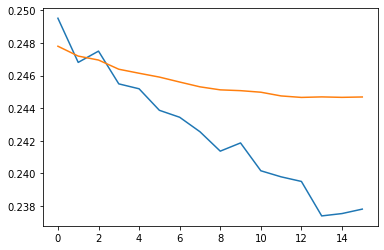

In [82]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [87]:
# model_cat.save("multi_inputs_class_model")

INFO:tensorflow:Assets written to: multi_inputs_class_model\assets


INFO:tensorflow:Assets written to: multi_inputs_class_model\assets


In [83]:
def multi_input_reg_lstm_full(shape_nlp, shape_num):
    input_nlp_fed = Input(shape=(shape_nlp[0], shape_nlp[1]))
    input_nlp_bce = Input(shape=(shape_nlp[0], shape_nlp[1]))
    input_num = Input(shape=(shape_num, 1))


    w = LSTM(100, return_sequences=True)(input_nlp_fed)
    w = Dropout(0.3)(w)
    #w = BatchNormalization()(w)
    w = LSTM(40, return_sequences=False)(w)
    w = Dropout(0.3)(w)
    w = Model(inputs=input_nlp_fed, outputs=w)


    x = LSTM(100, return_sequences=True)(input_nlp_bce)
    x = Dropout(0.3)(x)
    #x = BatchNormalization()(x)
    x = LSTM(40, return_sequences=False)(x)
    #x = Dropout(0.3)(x)
    x = Model(inputs=input_nlp_bce, outputs=x)

    # the second branch opreates on the second input
    y = LSTM(100, return_sequences=False)(input_num)
    y = Dropout(0.3)(y)
    #y = BatchNormalization()(y)
    # y = LSTM(40, return_sequences=False)(y)
    # y = Dropout(0.3)(y)
    y = Model(inputs=input_num, outputs=y)
    # combine the output of the two branches
    combined = concatenate([w.output, x.output, y.output])

    z = Dense(64, activation='relu')(combined)
    z = Dropout(0.3)(z)
    # classi = BatchNormalization()(z)
    # classi = Dense(64)(classi)
    # classi = LeakyReLU(0.3)(classi)
    # classi = Dropout(0.5)(classi)
    z = Dense(64, activation='relu')(z)
    z = Dropout(0.3)(z)
    out_reg = Dense(1, activation='linear')(z)
    
    # out_class = Dense(1, activation = 'sigmoid')(z)
    model = Model(inputs=[w.input, x.input, y.input], outputs=out_reg)

    return model

In [84]:
model_reg=multi_input_reg_lstm_full(lstm_shape, shape_num)
early_stop = EarlyStopping(monitor='val_loss', patience=3)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
optimizer = Adam(learning_rate=0.0001)
model_reg.compile(loss=['mse'], optimizer=optimizer)
history = model_reg.fit([X_fed_lstm_train, X_ecb_lstm_train, X_num_train], y_train_reg, epochs=50, batch_size=128, verbose=2,
    validation_data = ([X_fed_lstm_val, X_ecb_lstm_val, X_num_val], y_val_reg), callbacks=[early_stop, tensorboard_callback, ])

Epoch 1/50
8/8 - 19s - loss: 0.9947 - val_loss: 1.4107
Epoch 2/50
8/8 - 4s - loss: 0.9405 - val_loss: 1.3444
Epoch 3/50
8/8 - 3s - loss: 0.8848 - val_loss: 1.2822
Epoch 4/50
8/8 - 3s - loss: 0.8316 - val_loss: 1.2173
Epoch 5/50
8/8 - 3s - loss: 0.7848 - val_loss: 1.1421
Epoch 6/50
8/8 - 3s - loss: 0.7432 - val_loss: 1.0573
Epoch 7/50
8/8 - 3s - loss: 0.6736 - val_loss: 0.9643
Epoch 8/50
8/8 - 3s - loss: 0.6141 - val_loss: 0.8688
Epoch 9/50
8/8 - 8s - loss: 0.5224 - val_loss: 0.7745
Epoch 10/50
8/8 - 3s - loss: 0.5019 - val_loss: 0.6827
Epoch 11/50
8/8 - 3s - loss: 0.4174 - val_loss: 0.5981
Epoch 12/50
8/8 - 3s - loss: 0.3840 - val_loss: 0.5229
Epoch 13/50
8/8 - 3s - loss: 0.3579 - val_loss: 0.4702
Epoch 14/50
8/8 - 3s - loss: 0.3563 - val_loss: 0.4424
Epoch 15/50
8/8 - 3s - loss: 0.3322 - val_loss: 0.4360
Epoch 16/50
8/8 - 3s - loss: 0.2972 - val_loss: 0.4202
Epoch 17/50
8/8 - 3s - loss: 0.3189 - val_loss: 0.4011
Epoch 18/50
8/8 - 3s - loss: 0.2856 - val_loss: 0.3812
Epoch 19/50
8/8 - 

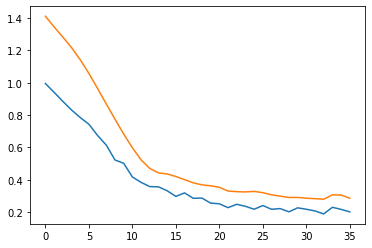

In [85]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [88]:
model_reg.save("multi_inputs_reg_model")

INFO:tensorflow:Assets written to: multi_inputs_reg_model\assets


INFO:tensorflow:Assets written to: multi_inputs_reg_model\assets


In [ ]:
mean_squared_error(y_train_reg, model.predict([X_fed_lstm_train, X_ecb_lstm_train, X_num_train]))**(1/2)

os.chdir('C:/Users/32mor/OneDrive/Documents/Polytechnique/NLP & Natixis/starting_kit/answer')

np.savetxt(f'./{version}/pred_reg.txt', y_test_reg, fmt='%.3f')
np.savetxt(f'./{version}/pred_classif.txt', y_test_class, fmt='%d')

In [ ]:
(y_test_class>0.5).sum()

In [ ]:
os.chdir('..')
print('zipping it...')
shutil.make_archive('answer', 'zip', './answer/')
shutil.rmtree('./answer/')
os.chdir('../..')
print('done!')

In [ ]:
os.chdir('C:/Users/32mor/OneDrive/Documents/Polytechnique/NLP & Natixis/starting_kit/answer')